In [1]:
import pandas as pd
import os, time, glob, sys
from collections import Counter
import mne
import numpy as np
import matplotlib.pyplot as plt

# Import data (subwise - response & raw)

In [ ]:
response_df = "C:/Users/USER/Downloads/eeg-fnirs-face-word-eeg/response-data/total_response_data.csv"
# 피험자별 데이터 불러오기 ('cey','kjy','lyj')
sub_name = 'cey'
sub_response_df = pd.read_csv(response_df).drop(['Unnamed: 0'],axis=1).query(f'subject == "{sub_name}"').reset_index().drop(['index'],axis=1)

In [8]:
sub_response_df.head()

time type component response type_stim scroll  \
0  63.5401  EXP   unnamed     Left     image      =   
1  70.4303  EXP   unnamed    Right     image      =   
2  76.1352  EXP   unnamed    Right     image      =   
3  81.1578  EXP   unnamed    Right     image      =   
4  85.9116  EXP   unnamed     Left     image      =   

                                             stimuli          filename  \
0    'stimuli-ha-sa\\incong-cong-HA\\cong-ha-39.png'    cong-ha-39.png   
1  'stimuli-ha-sa\\incong-cong-HA\\incong-ha-19.png'  incong-ha-19.png   
2  'stimuli-ha-sa\\incong-cong-HA\\incong-ha-23.png'  incong-ha-23.png   
3  'stimuli-ha-sa\\incong-cong-SA\\incong-sa-19.png'  incong-sa-19.png   
4    'stimuli-ha-sa\\incong-cong-SA\\cong-sa-46.png'    cong-sa-46.png   

  congruency emotion  response_time  correct subject  
0       cong   happy         3.5813     True     cey  
1     incong   happy         1.4268     True     cey  
2     incong   happy         0.9624     True     cey  
3     incong     sad         1.2513     True     cey  
4       cong     sad         1.0334     True     cey

In [5]:
path = 'C:/Users/USER/Downloads/eeg-fnirs-face-word-eeg/eeg/'
#kjy의 경우 split -4
raw_name = [f for f in os.listdir(path) if f.endswith('.vhdr') and f.split('_')[-3]==sub_name][0]
raw = mne.io.read_raw_brainvision(path+raw_name, preload=True)
print(raw.info)

Extracting parameters from C:/Users/USER/Downloads/eeg-fnirs-face-word-eeg/eeg/face-word_stroop_cey_0530_1.vhdr...
Setting channel info structure...


C:\Users\USER\AppData\Local\Temp\ipykernel_126944\1235199471.py:3: RuntimeWarning: Online software filter detected. Using software filter settings and ignoring hardware values
  raw = mne.io.read_raw_brainvision(path+raw_name, preload=True)


Reading 0 ... 151874  =      0.000 ...   607.496 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: PO9, O1, F7, Oz, O2, PO10, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 27 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 40.0 Hz
 meas_date: 2025-05-30 14:22:20 UTC
 nchan: 27
 projs: []
 sfreq: 250.0 Hz
>


In [10]:
# montage 설정: standard_1020
montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

<RawBrainVision | face-word_stroop_cey_0530_1.eeg, 27 x 151875 (607.5 s), ~31.3 MB, data loaded>

## Marker 설정

In [11]:
events, event_types = mne.events_from_annotations(raw)
print(event_types)

Used Annotations descriptions: ['END/finish', 'FIX/fixation', 'New Segment/', 'RES/left', 'RES/right', 'STIM/Stimuli']
{'END/finish': 10001, 'FIX/fixation': 10002, 'New Segment/': 99999, 'RES/left': 10003, 'RES/right': 10004, 'STIM/Stimuli': 10005}


In [12]:
# 기존 annotation에서 'STIM/Stimuli' 만 제외
orig_annots = raw.annotations
keep_mask = orig_annots.description != 'STIM/Stimuli'
kept_annots = orig_annots[keep_mask]

# 1. 자극 이벤트 추출 (10005번: STIM/Stimuli)
stim_annots = [ann for ann in raw.annotations if ann['description'] == 'STIM/Stimuli']

new_descriptions = [f"{row['emotion']}_{row['congruency']}" for _, row in sub_response_df.iterrows()]

# 3. onset, duration 추출
onsets = [ann['onset'] for ann in stim_annots]
durations = [ann['duration'] for ann in stim_annots]

# 4. 새 Annotations 객체 생성 (기존 orig_time 유지)
new_annots = mne.Annotations(
    onset=onsets,
    duration=durations,
    description=new_descriptions,
    orig_time=raw.annotations.orig_time
)

# new_annots는 우리가 만든 happy/sad + cong/incong 주석
# 이제 둘을 합쳐서 다시 세팅
merged_annots = kept_annots + new_annots
raw.set_annotations(merged_annots)

<RawBrainVision | face-word_stroop_cey_0530_1.eeg, 27 x 151875 (607.5 s), ~31.3 MB, data loaded>

In [13]:
print(raw.annotations)
print(set(raw.annotations.description))

<Annotations | 296 segments: END/finish (1), FIX/fixation (107), New ...>
{'FIX/fixation', 'sad_incong', 'New Segment/', 'sad_cong', 'RES/left', 'END/finish', 'happy_incong', 'happy_cong', 'RES/right'}


# Preprocessing

## bpf 1-40Hz

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 40.00 Hz: -6.02, -6.02 dB

Using matplotlib as 2D backend.


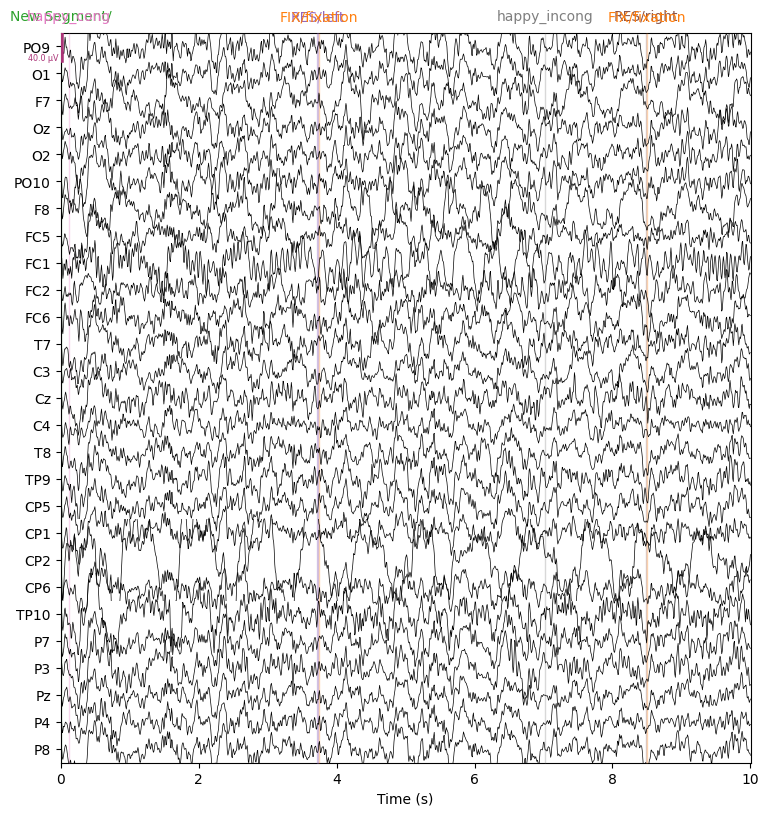

In [14]:
filtered_data = raw.filter(l_freq=1, h_freq=40, method ='iir')
filtered_data.plot(n_channels=len(filtered_data.ch_names), show_scrollbars=False)
plt.close()

## ICA

In [15]:
ica = mne.preprocessing.ICA(method="infomax", random_state=1) # we used "infomax" algorithm in EEGLAB
ica.fit(filtered_data)

Fitting ICA to data using 27 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 27 components
 
Fitting ICA took 16.7s.


<ICA | raw data decomposition, method: infomax (fit in 145 iterations on 151875 samples), 27 ICA components (27 PCA components available), channel types: eeg, no sources marked for exclusion>

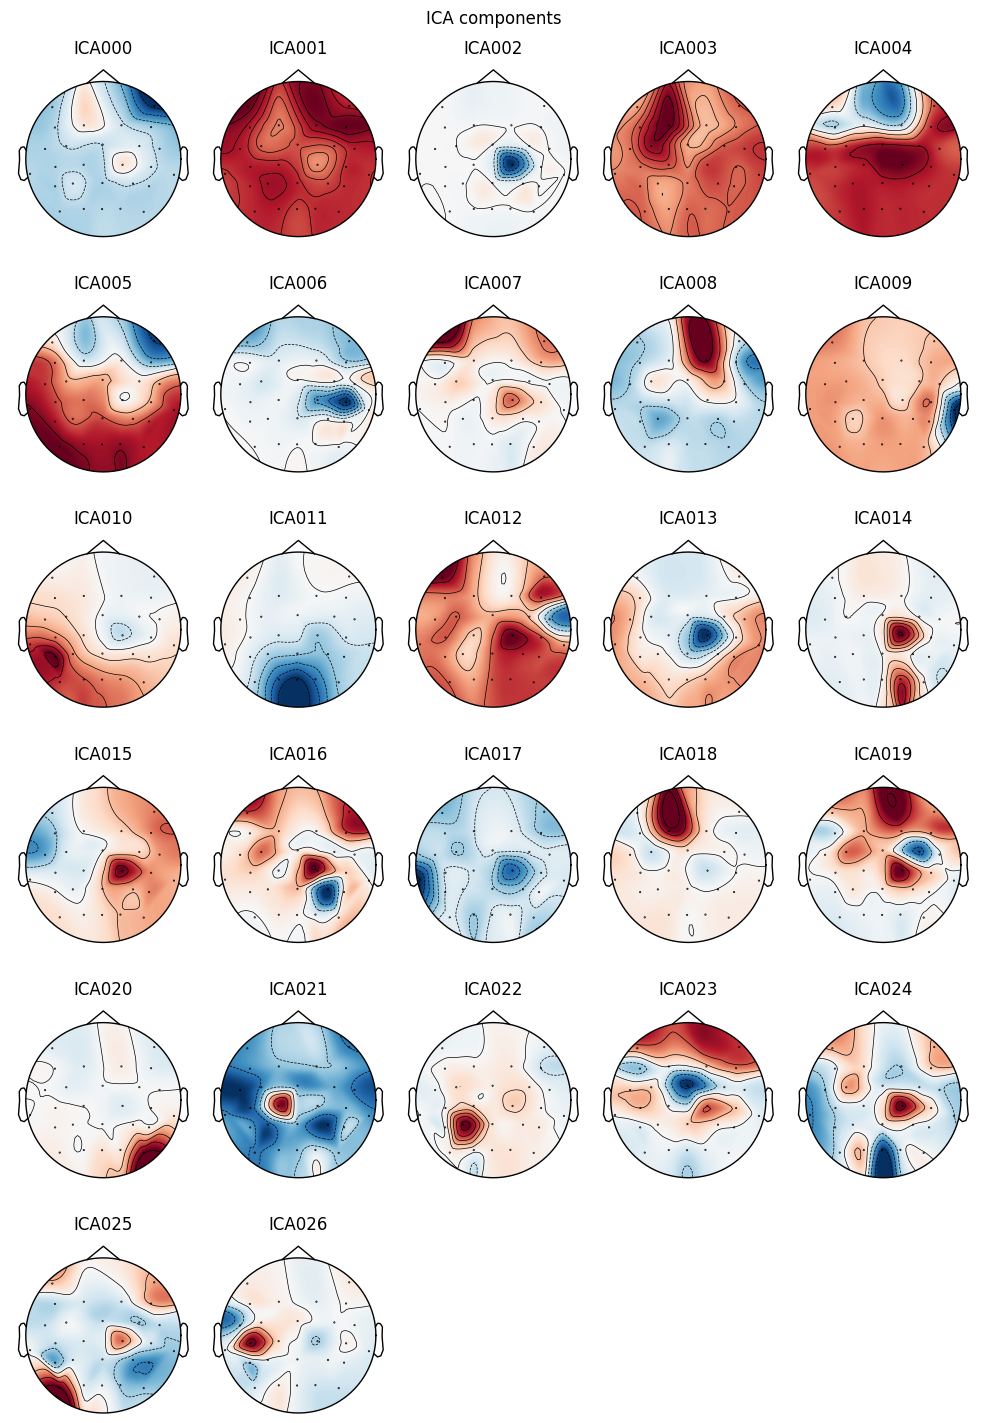

In [16]:
ica.plot_components(inst=filtered_data, picks=range(len(filtered_data.ch_names)))
plt.close()

Creating RawArray with float64 data, n_channels=27, n_times=151875
    Range : 0 ... 151874 =      0.000 ...   607.496 secs
Ready.


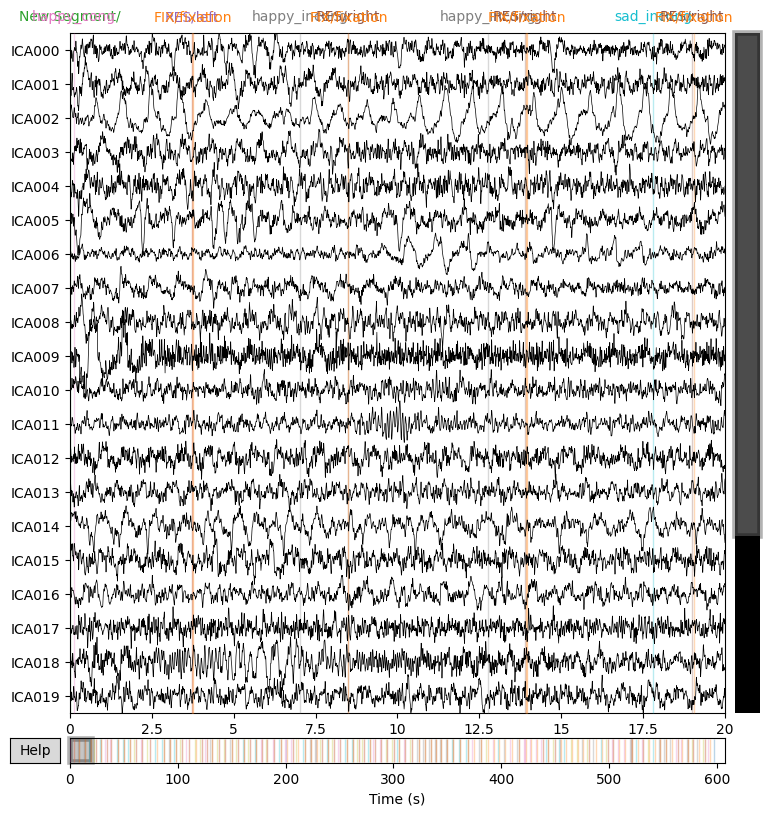

In [17]:
ica.plot_sources(filtered_data, show=True)
plt.close()  # 필요 시 닫기

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
303 matching events found
No baseline correction applied
0 projection items activated


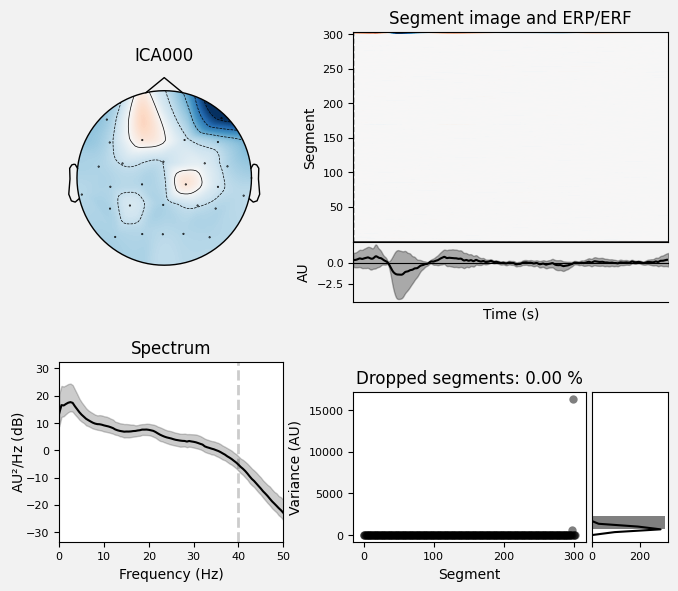

[<Figure size 700x600 with 6 Axes>]

In [19]:
ica.plot_properties(filtered_data, picks=0) #picks range: 0~len(filtered_data.ch_names)

In [20]:
ica.exclude = [0]

In [21]:
ica.apply(filtered_data)

Applying ICA to Raw instance
    Transforming to ICA space (27 components)
    Zeroing out 1 ICA component
    Projecting back using 27 PCA components


<RawBrainVision | face-word_stroop_cey_0530_1.eeg, 27 x 151875 (607.5 s), ~31.3 MB, data loaded>

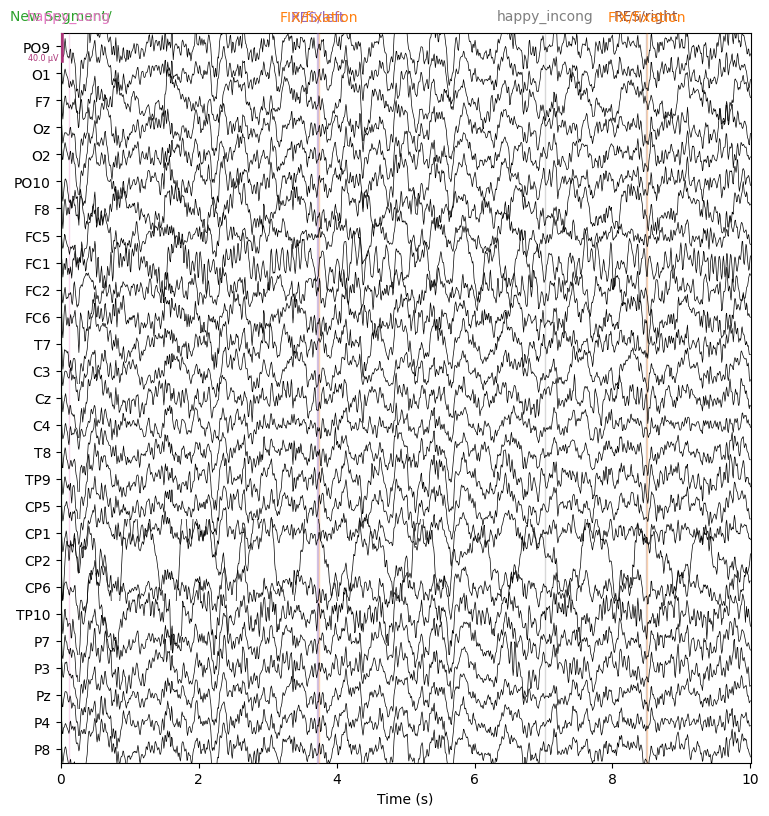

In [22]:
filtered_data.plot(n_channels=len(filtered_data.ch_names), show_scrollbars=False)
plt.close()

# Extract epochs

In [23]:
event, event_types = mne.events_from_annotations(filtered_data)
print(event_types)

Used Annotations descriptions: ['END/finish', 'FIX/fixation', 'New Segment/', 'RES/left', 'RES/right', 'happy_cong', 'happy_incong', 'sad_cong', 'sad_incong']
{'END/finish': 10001, 'FIX/fixation': 10002, 'New Segment/': 99999, 'RES/left': 10003, 'RES/right': 10004, 'happy_cong': 10005, 'happy_incong': 10006, 'sad_cong': 10007, 'sad_incong': 10008}


In [24]:
event_id = {
    'happy_cong': 10005,
    'happy_incong': 10006,
    'sad_cong': 10007,
    'sad_incong': 10008,
}

events, _ = mne.events_from_annotations(filtered_data)

epochs = mne.Epochs(
    filtered_data, events, event_id=event_id,
    tmin=-0.2, tmax=1.0,  # 200ms 전부터 1초까지
    baseline=(None, 0),   # baseline 정규화 (자극 전 평균)
    preload=True
)

Used Annotations descriptions: ['END/finish', 'FIX/fixation', 'New Segment/', 'RES/left', 'RES/right', 'happy_cong', 'happy_incong', 'sad_cong', 'sad_incong']
Not setting metadata
107 matching events found
Setting baseline interval to [-0.2, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 107 events and 301 original time points ...
1 bad epochs dropped


In [25]:
# emotion-congruency-wise
happy_cong_epochs = epochs['happy_cong']
happy_incong_epohcs = epochs['happy_incong']
sad_incong_epochs = epochs['sad_incong']
sad_cong_epochs = epochs['sad_cong']

# emotion-wise (happy vs sad)
happy_epochs = mne.concatenate_epochs([epochs['happy_cong'], epochs['happy_incong']])
sad_epochs   = mne.concatenate_epochs([epochs['sad_cong'], epochs['sad_incong']])

#congruency-wise
cong_epochs = mne.concatenate_epochs([epochs['happy_cong'], epochs['sad_cong']])
incong_epochs = mne.concatenate_epochs([epochs['happy_incong'], epochs['sad_incong']])

Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
55 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
55 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)


C:\Users\USER\AppData\Local\Temp\ipykernel_126944\714537998.py:8: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  happy_epochs = mne.concatenate_epochs([epochs['happy_cong'], epochs['happy_incong']])
C:\Users\USER\AppData\Local\Temp\ipykernel_126944\714537998.py:9: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  sad_epochs   = mne.concatenate_epochs([epochs['sad_cong'], epochs['sad_incong']])
C:\Users\USER\AppData\Local\Temp\ipykernel_126944\714537998.py:12: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  cong_epochs = mne.concatenate_epochs([epochs['happy_cong'], epochs['sad_cong']])
C:\Users\USER\AppData\Local\Temp\ipykernel_126944\714537998.py:13: RuntimeWarning: Concatenation of Annotations within Epochs is not supported yet. All annotations will be dropped.
  incong_epochs = mne.c

## emotion-wise

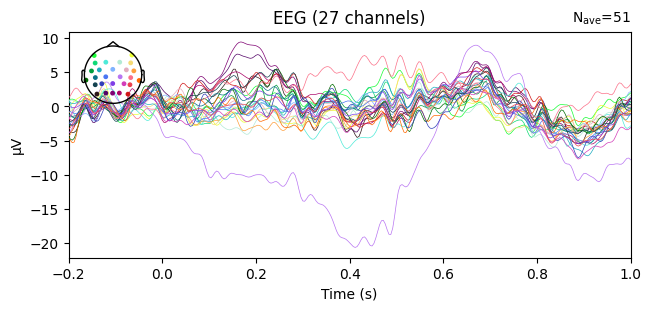

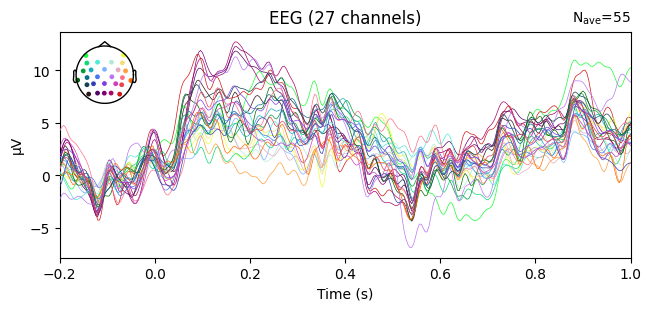

In [26]:
#emotion-wise
happy_evoked = happy_epochs.average()
fig = happy_evoked.plot()

sad_evoked = sad_epochs.average()
fig = sad_evoked.plot()

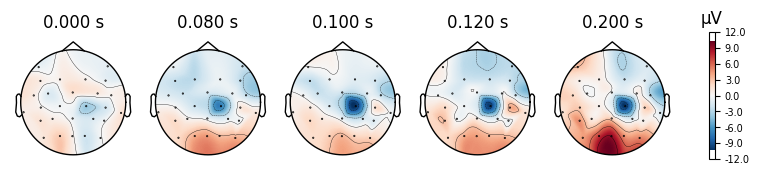

No projector specified for this dataset. Please consider the method self.add_proj.


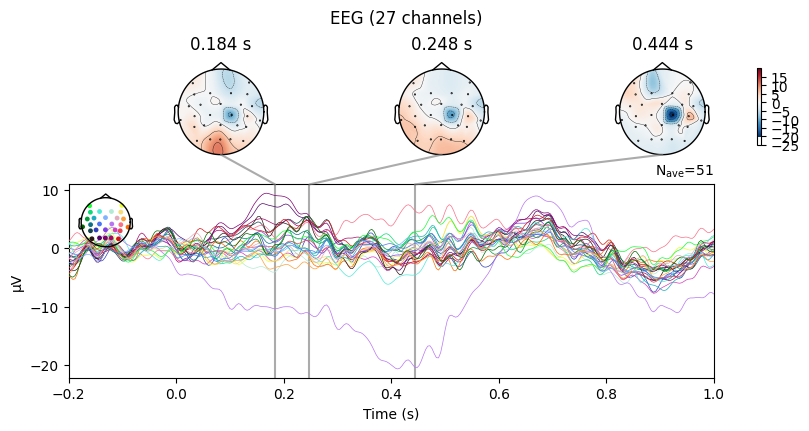

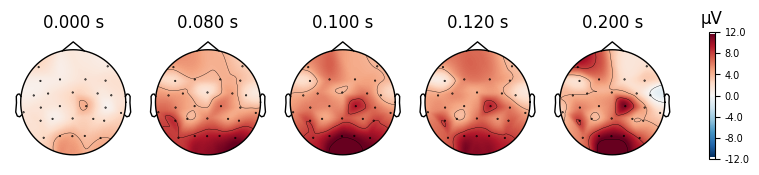

No projector specified for this dataset. Please consider the method self.add_proj.


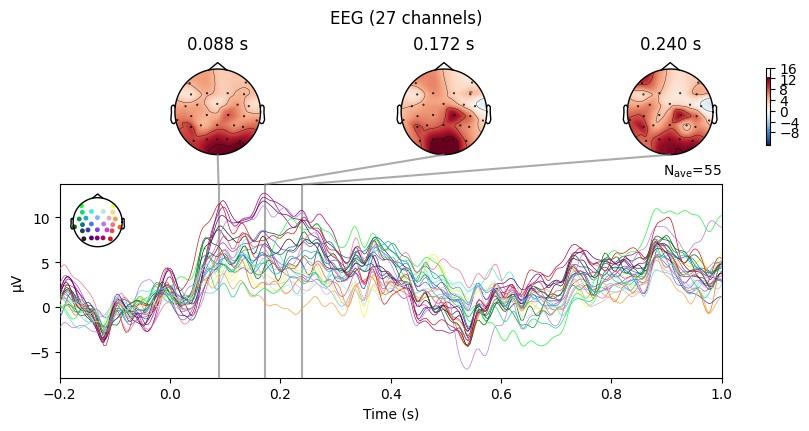

In [27]:
happy_evoked.plot_topomap(
    times=[0.0, 0.08, 0.1, 0.12, 0.2],     # 원하는 시간점
    ch_type='eeg',
    show_names=False)
plt.close()

happy_evoked.plot_joint(picks="eeg")
plt.close()

sad_evoked.plot_topomap(
    times=[0.0, 0.08, 0.1, 0.12, 0.2],     # 원하는 시간점
    ch_type='eeg',
    show_names=False)
plt.close()

sad_evoked.plot_joint(picks="eeg")
plt.close()

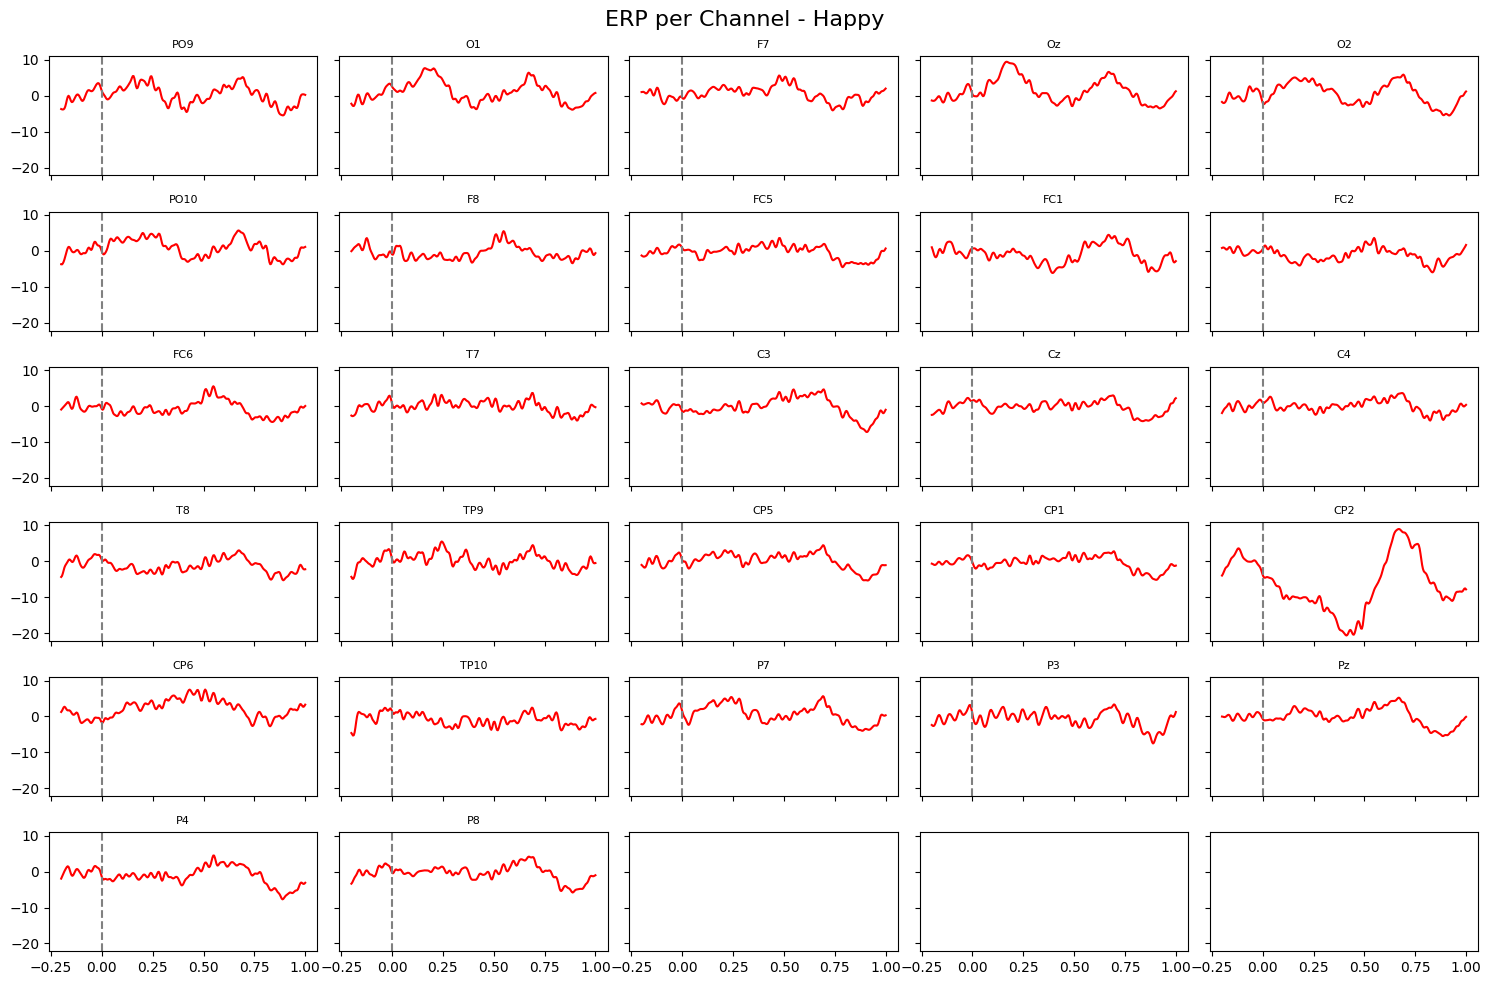

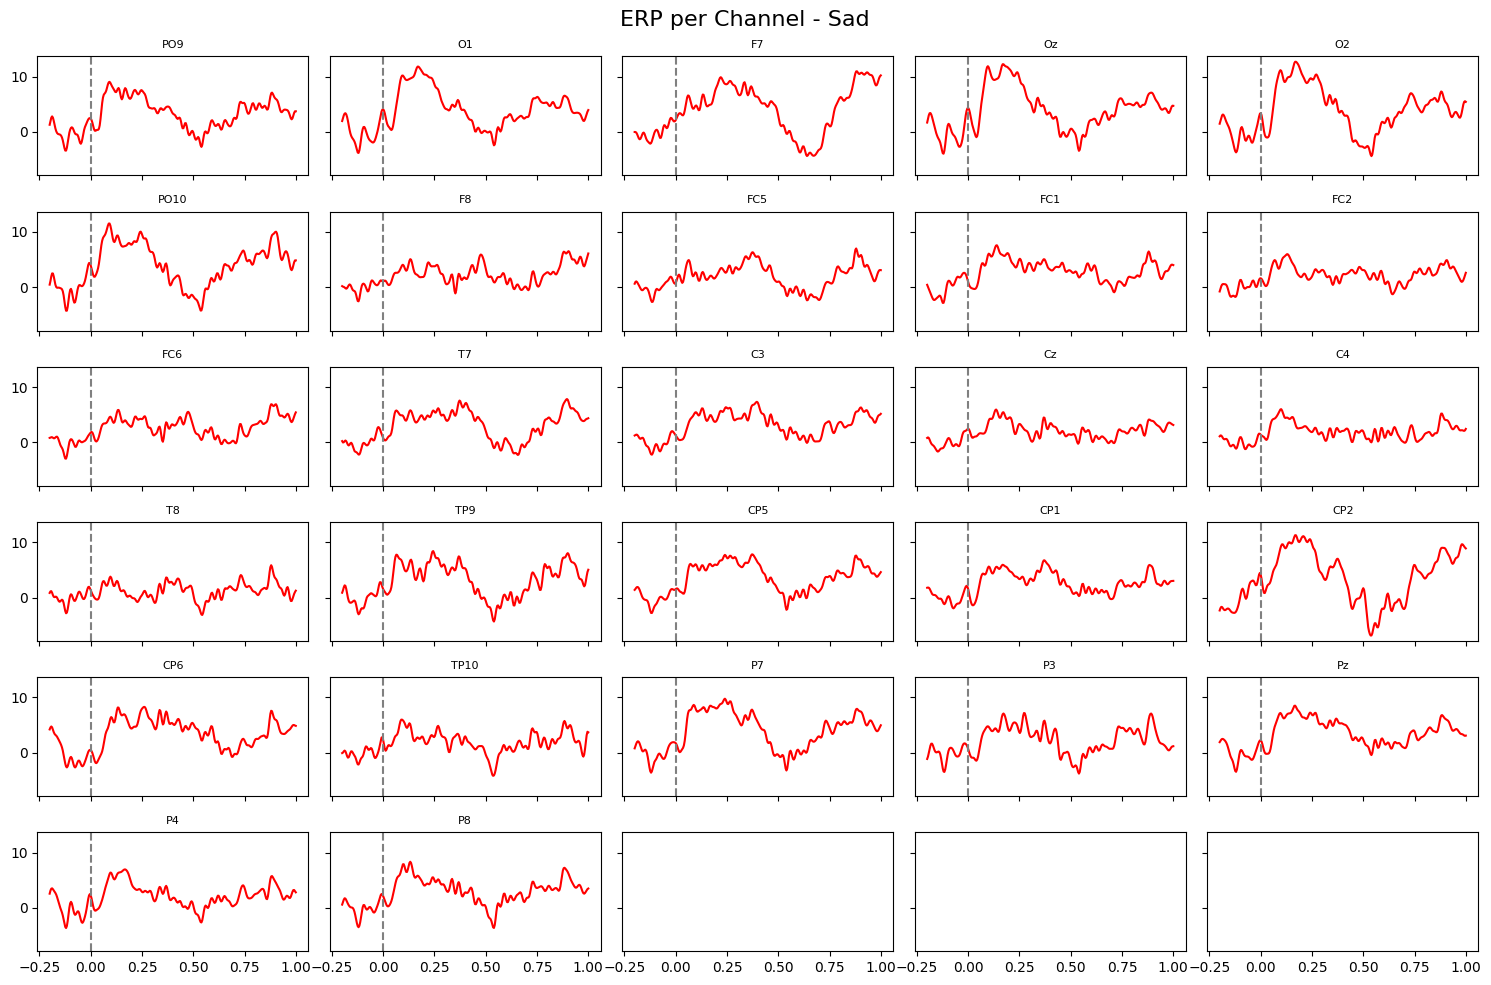

In [28]:
data = happy_evoked.data * 1e6  # V → μV
times = happy_evoked.times
ch_names = happy_evoked.ch_names

n_channels = len(ch_names)
n_rows = 6
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(n_channels):
    axes[i].plot(times, data[i], color='r')
    axes[i].set_title(ch_names[i], fontsize=8)
    axes[i].axvline(0, color='gray', linestyle='--')  # 자극 시간선

fig.suptitle("ERP per Channel - Happy", fontsize=16)
plt.tight_layout()
plt.show()

data = sad_evoked.data * 1e6  # V → μV
times = sad_evoked.times
ch_names = sad_evoked.ch_names

n_channels = len(ch_names)
n_rows = 6
n_cols = 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10), sharex=True, sharey=True)
axes = axes.flatten()

for i in range(n_channels):
    axes[i].plot(times, data[i], color='r')
    axes[i].set_title(ch_names[i], fontsize=8)
    axes[i].axvline(0, color='gray', linestyle='--')  # 자극 시간선

fig.suptitle("ERP per Channel - Sad", fontsize=16)
plt.tight_layout()
plt.show()

## congruency-wise

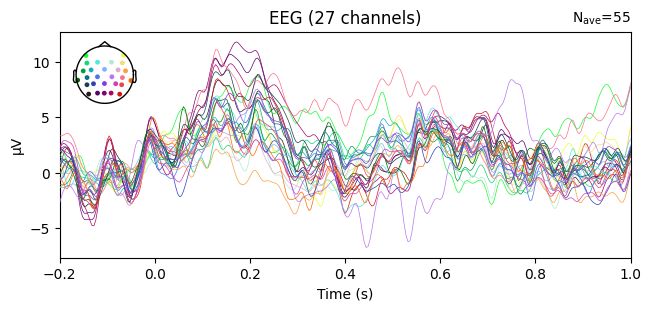

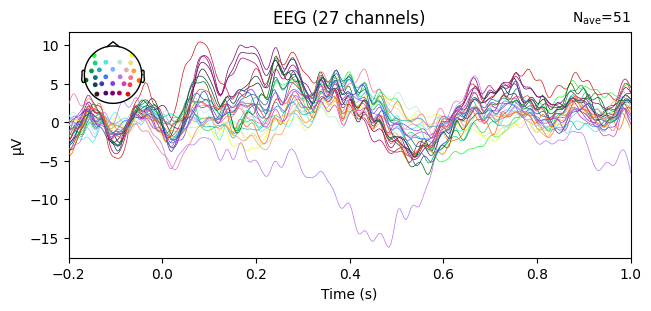

In [29]:
#congruency-wise
cong_evoked = cong_epochs.average()
fig = cong_evoked.plot()

incong_evoked = incong_epochs.average()
fig = incong_evoked.plot()

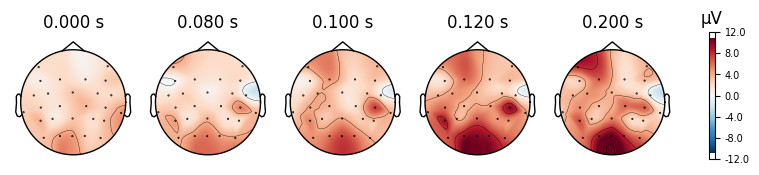

No projector specified for this dataset. Please consider the method self.add_proj.


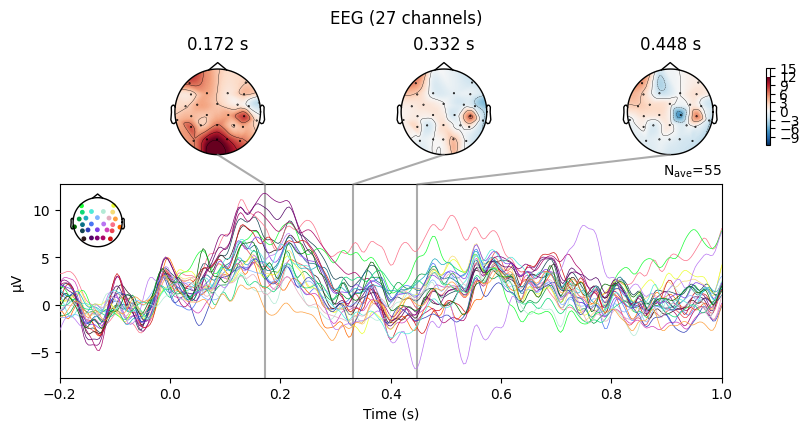

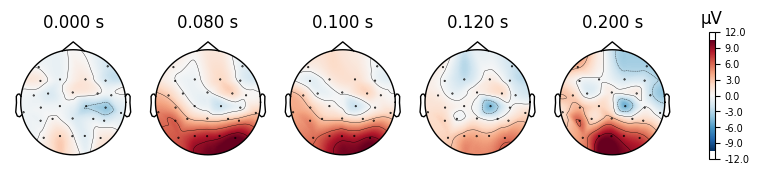

No projector specified for this dataset. Please consider the method self.add_proj.


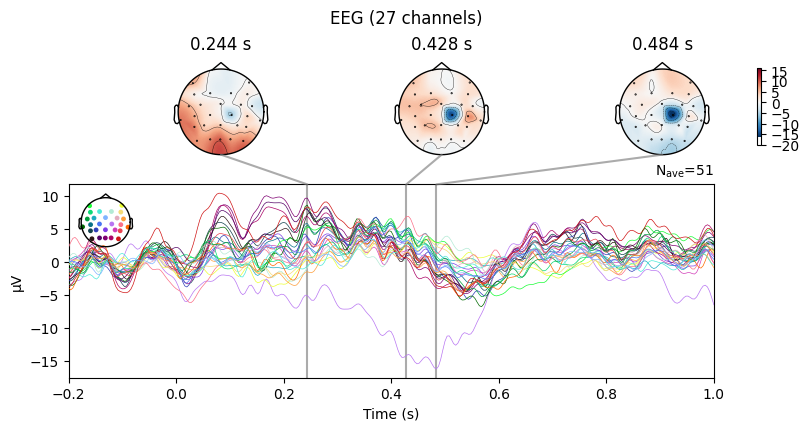

In [30]:
cong_evoked.plot_topomap(
    times=[0.0, 0.08, 0.1, 0.12, 0.2],     # 원하는 시간점
    ch_type='eeg',
    show_names=False)
plt.close()

cong_evoked.plot_joint(picks="eeg")
plt.close()

incong_evoked.plot_topomap(
    times=[0.0, 0.08, 0.1, 0.12, 0.2],     # 원하는 시간점
    ch_type='eeg',
    show_names=False)
plt.close()

incong_evoked.plot_joint(picks="eeg")
plt.close()

## emotion-congruency-wise

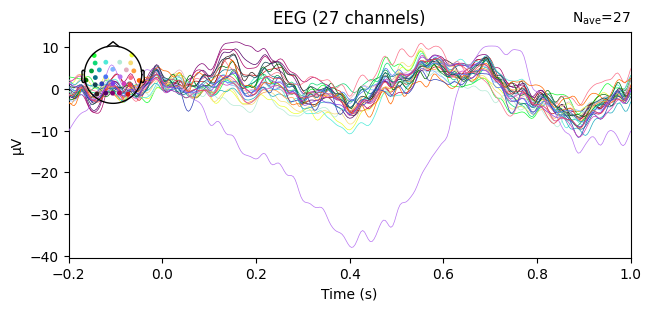

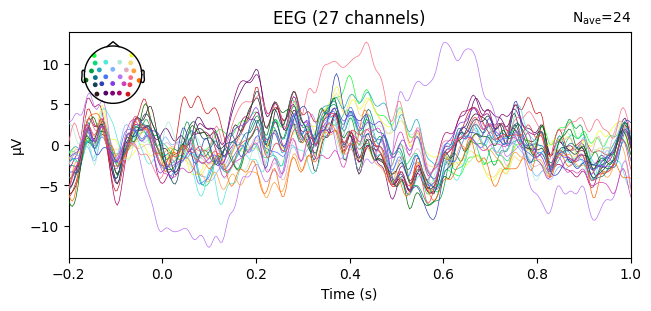

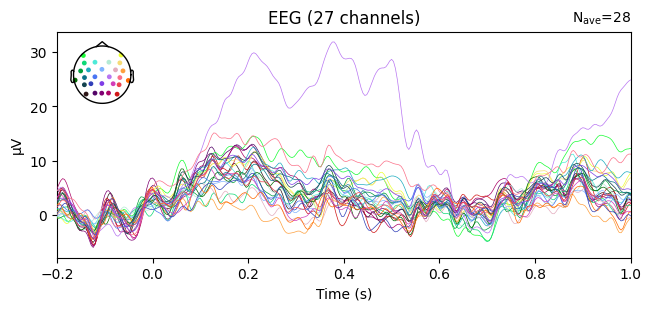

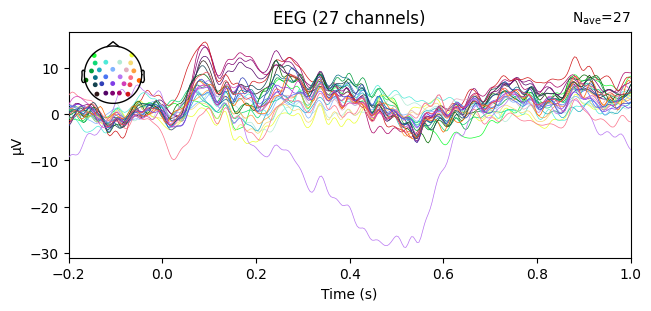

In [31]:
#emotion-congruency
epochs['happy_cong'].average().plot()
plt.close()

epochs['happy_incong'].average().plot()
plt.close()

epochs['sad_cong'].average().plot()
plt.close()

epochs['sad_incong'].average().plot()
plt.close()

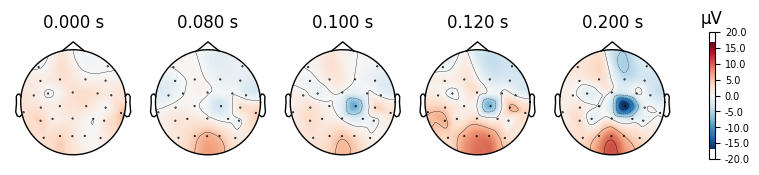

No projector specified for this dataset. Please consider the method self.add_proj.


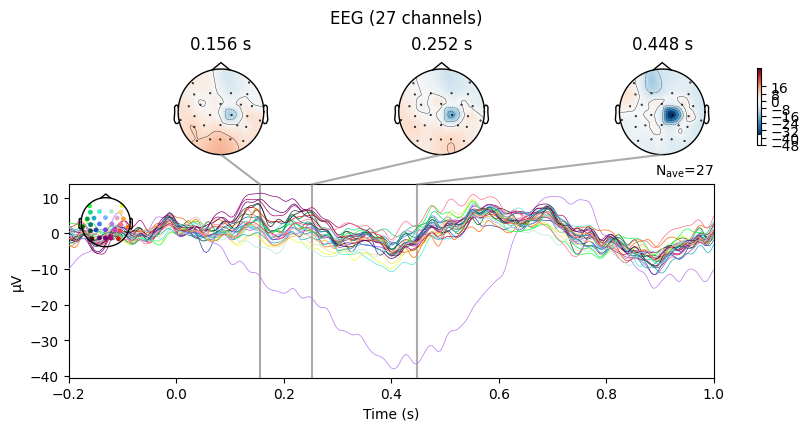

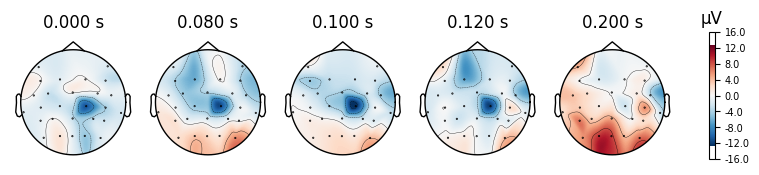

No projector specified for this dataset. Please consider the method self.add_proj.


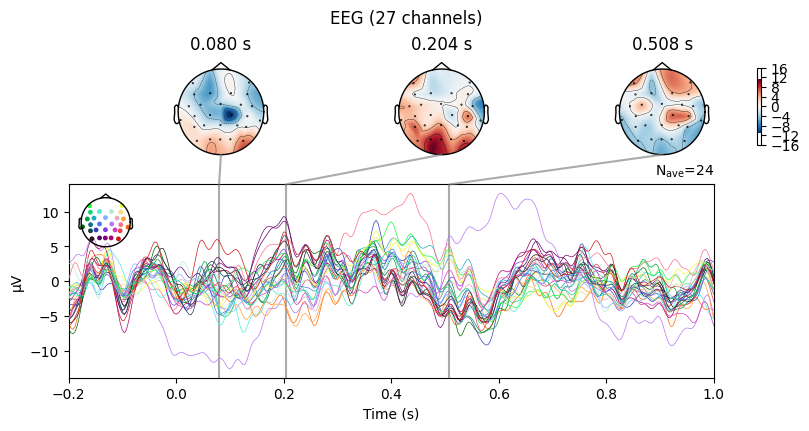

In [32]:
#happy-cong / happy-incong
happy_cong_evoked = epochs['happy_cong'].average()
happy_incong_evoked = epochs['happy_incong'].average()

happy_cong_evoked.plot_topomap(
    times=[0.0, 0.08, 0.1, 0.12, 0.2],     # 원하는 시간점
    ch_type='eeg',
    show_names=False)
plt.close()

happy_cong_evoked.plot_joint(picks="eeg")
plt.close()

happy_incong_evoked.plot_topomap(
    times=[0.0, 0.08, 0.1, 0.12, 0.2],     # 원하는 시간점
    ch_type='eeg',
    show_names=False)
plt.close()

happy_incong_evoked.plot_joint(picks="eeg")
plt.close()

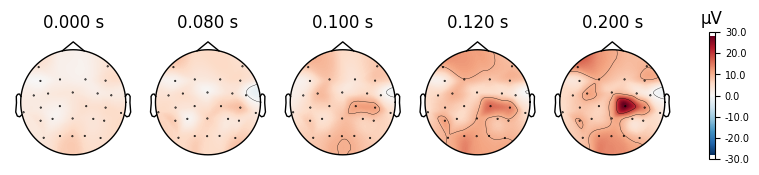

No projector specified for this dataset. Please consider the method self.add_proj.


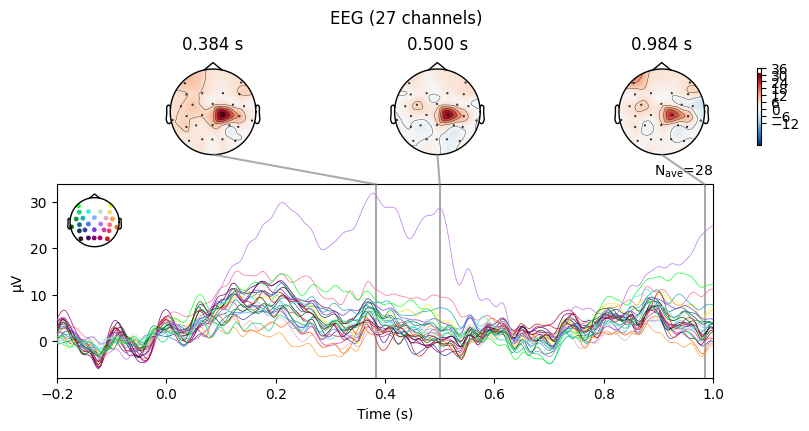

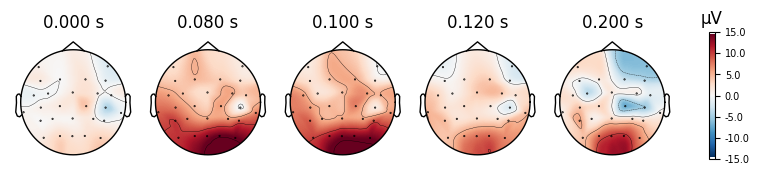

No projector specified for this dataset. Please consider the method self.add_proj.


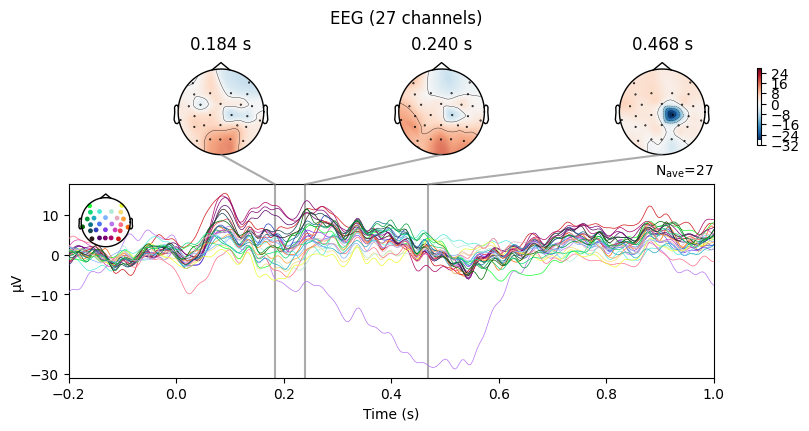

In [33]:
#sad-cong / sad-incong
sad_cong_evoked = epochs['sad_cong'].average()
sad_incong_evoked = epochs['sad_incong'].average()

sad_cong_evoked.plot_topomap(
    times=[0.0, 0.08, 0.1, 0.12, 0.2],     # 원하는 시간점
    ch_type='eeg',
    show_names=False)
plt.close()

sad_cong_evoked.plot_joint(picks="eeg")
plt.close()

sad_incong_evoked.plot_topomap(
    times=[0.0, 0.08, 0.1, 0.12, 0.2],     # 원하는 시간점
    ch_type='eeg',
    show_names=False)
plt.close()

sad_incong_evoked.plot_joint(picks="eeg")
plt.close()

# Save preprocessed data

In [334]:
saved_path = f'C:/Users/USER/Downloads/eeg-fnirs-face-word-eeg/preprocessed_eeg/{sub_name}/'
# Raw EEG (필터링/ICA 완료 후)
filtered_data.save(saved_path+f'{sub_name}_raw_filt_ica.fif', overwrite=True)

# Epochs (stim 기반 epoching 완료 후)
epochs.save(saved_path+f'{sub_name}-epohs.fif', overwrite=True)

# Evoked EEG
happy_evoked.save(saved_path+f'{sub_name}-happy-ave.fif', overwrite=True)
sad_evoked.save(saved_path+f'{sub_name}-sad-ave.fif', overwrite=True)

cong_evoked.save(saved_path+f'{sub_name}-cong-ave.fif', overwrite=True)
incong_evoked.save(saved_path+f'{sub_name}-incong-ave.fif', overwrite=True)

happy_cong_evoked.save(saved_path+f'{sub_name}-happy-cong-ave.fif', overwrite=True)
happy_incong_evoked.save(saved_path+f'{sub_name}-happy-incong-ave.fif', overwrite=True)

sad_cong_evoked.save(saved_path+f'{sub_name}-sad-cong-ave.fif', overwrite=True)
sad_incong_evoked.save(saved_path+f'{sub_name}-sad-incong-ave.fif', overwrite=True)

Writing C:\Users\USER\Downloads\eeg-fnirs-face-word-eeg\preprocessed_eeg\kjy\kjy_raw_filt_ica.fif
Closing C:\Users\USER\Downloads\eeg-fnirs-face-word-eeg\preprocessed_eeg\kjy\kjy_raw_filt_ica.fif
[done]


C:\Users\USER\AppData\Local\Temp\ipykernel_28744\4200456872.py:3: RuntimeWarning: This filename (C:\Users\USER\Downloads\eeg-fnirs-face-word-eeg\preprocessed_eeg\kjy\kjy_raw_filt_ica.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  filtered_data.save(saved_path+f'{sub_name}_raw_filt_ica.fif', overwrite=True)
C:\Users\USER\AppData\Local\Temp\ipykernel_28744\4200456872.py:6: RuntimeWarning: This filename (C:/Users/USER/Downloads/eeg-fnirs-face-word-eeg/preprocessed_eeg/kjy/kjy-epohs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs.save(saved_path+f'{sub_name}-epohs.fif', overwrite=True)


In [ ]:
# Evoked 불러오기
#happy_evoked = mne.read_evokeds(saved_path+f'{sub_name}-happy-cong-ave.fif', condition=None)  # 리스트로 불러옴